## $G_i, B_i , g_i$ multiplication order problem
$$B_2 \Lambda_1 u + B_1 \Lambda_2 u + \alpha B_1 B_2 u + \gamma \Lambda_1 \Lambda_2 u = B_1 G_1 g_1 + G_2 B_2 g_2$$
При реализации метода выяснилось, что порядок умножения матриц при вычислении $F =  B_1 G_1 g_1 + G_2 B_2 g_2$ иной.
### Нужно:
    1. Исследовать различные варианты умножений.
    2. Написать теоритическое обоснование.

In [1]:
import sys
sys.path.append("../..")
import numpy as np
import lib.variational_method.eigenvalues as eigenvalues
import lib.variational_method.matrixes as matrixes

Будем смотреть на прямоугольный $x^2 + y^2$

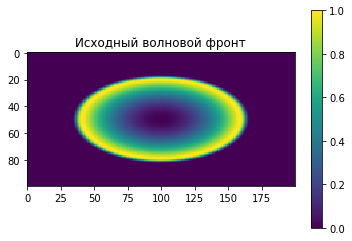

In [52]:
import matplotlib.pyplot as plt
from lib.data import super_gauss, normalize
from lib.mesurements import mse
%matplotlib inline
N, M = 100, 200
x, y = np.mgrid[-np.pi:np.pi:1j * N, -np.pi:np.pi:1j * M]
gauss = super_gauss(x, y, 2, 20)
h1, h2 = 2 * np.pi / N, 2  * np.pi / M
front = x**2 + y**2
g1, g2 = 2 * x * gauss, 2 * y * gauss
front = normalize(front)
front *= gauss
front = normalize(front)
plt.imshow(front)
plt.title('Исходный волновой фронт')
plt.colorbar()

# 1. $ F = B_1 G_1 g_1 + G_2B_2g2 $ 

# 2. $ F = B_1 G_1 g_1 + B_2G_2g_2 $ 

# 3. $F = G_1B_1g_1 + B_2G_2g_2$

# 4. $F = g_1 G_1 B_1  + g_2 G_2 B_2 $

# 4. $F = B_1^T G_1 g_1 + B_2 G_1^T g_1$

# 5. $F = (G_1 g_1 ) B_2 + (B_1 g_2) G_2$

2.0449212375081243e-05


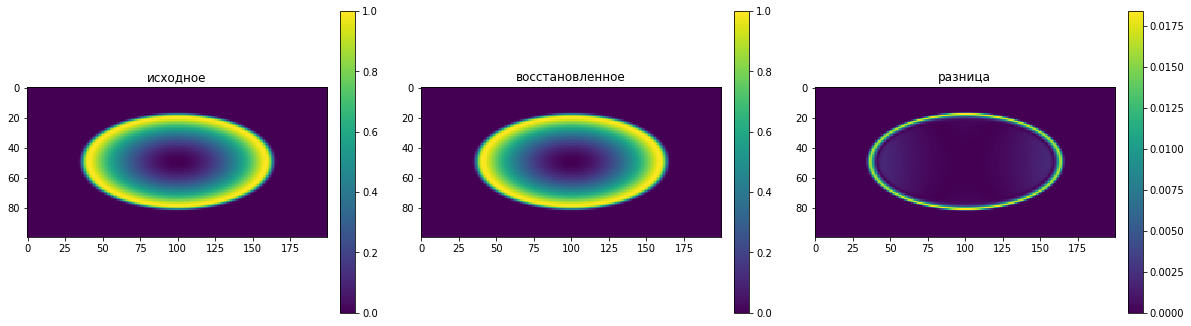

In [53]:
def _f1(g1, h1):
    """
    F1 составлющая матрицы F
    :param g1: 2d array. Градиент по x
    :param h1: шаг сетки по x
    :return: 2d array
    """
    dim = g1.shape
    tmp = np.dot(matrixes.create_g1(dim[0], h1), g1)
    return np.dot(tmp, matrixes.create_b(dim[1], h2))


def _f2(g2, h2):
    """
    F2 составляющая матрицы F
    :param g2: 2d array. Градиент по y
    :param h2: шаг сетки по y
    :return: 2d array
    """
    dim = g2.shape
    tmp = np.dot(matrixes.create_b(dim[0], h1), g2)
    return np.dot(tmp, matrixes.create_g2(dim[1], h2))


def _get_f_matrix(g1, g2, h1, h2):
    """
    Матрица F. Правая часть в разностной схеме метода.
    :param g1: 2d array. Градиент по x
    :param g2: 2d array. Градиент по y
    :param h1: Шаг сетки по x
    :param h2: Шаг сетки по y
    :return: 2d array
    """
    return _f1(g1, h1) + _f2(g2, h2)


def method(g1, g2, h1, h2, alpha, gamma):
    """
    Метод. Принимает градиенты по x, y. Параметры регуляризации alga, gamma.
    Возвращает восстановленный волновой фронт.
    :param g1: 2d array. Градиент по x
    :param g2: 2d array. Градиент по y
    :param h1: Шаг сетки по x
    :param h2: Шаг сетки по y
    :param alpha: параметр регуляризации
    :param gamma: параметр регуляризации
    :return:
    """
    f = np.fft.fft2(_get_f_matrix(g1, g2, h1, h2))

    lambda1 = eigenvalues.get_lambda(f.shape[0], h1)
    lambda2 = eigenvalues.get_lambda(f.shape[1], h2)

    mu1 = eigenvalues.get_mu(f.shape[0], h1)
    mu2 = eigenvalues.get_mu(f.shape[1], h2)

    res = np.zeros(f.shape, dtype=complex)
    for k in range(res.shape[0]):
        for l in range(res.shape[1]):
            res[k][l] = (lambda1[k] * mu2[l] + mu1[k] * lambda2[l] +
                         alpha * mu1[k] * mu2[l] + gamma * lambda1[k] * lambda2[l])
    res = np.fft.ifft2(f / res)
    return np.real(res)

restored_front = method(g1, g2, h1, h2, 0.00000000001, 0.00001)
report(restored_front)

# 6. $F = G_1 (g_1 B_2) + B_1 (g_2 G_2)$

2.1027802185540135e-05


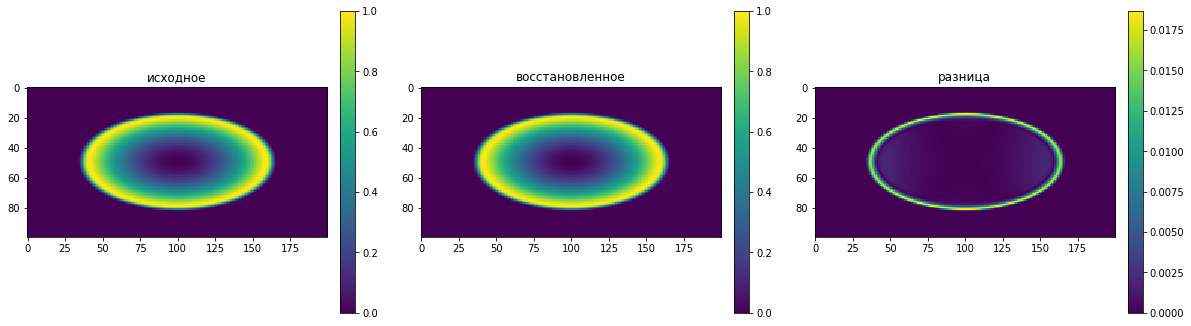

In [56]:
def _f1(g1, h1):
    """
    F1 составлющая матрицы F
    :param g1: 2d array. Градиент по x
    :param h1: шаг сетки по x
    :return: 2d array
    """
    dim = g1.shape
    tmp = np.dot(g1, matrixes.create_b(dim[1], h2))
    return np.dot(matrixes.create_g1(dim[0], h1), tmp)


def _f2(g2, h2):
    """
    F2 составляющая матрицы F
    :param g2: 2d array. Градиент по y
    :param h2: шаг сетки по y
    :return: 2d array
    """
    dim = g2.shape
    tmp = np.dot(g2, matrixes.create_g2(dim[1], h2))
    return np.dot(matrixes.create_b(dim[0], h2), tmp)


def _get_f_matrix(g1, g2, h1, h2):
    """
    Матрица F. Правая часть в разностной схеме метода.
    :param g1: 2d array. Градиент по x
    :param g2: 2d array. Градиент по y
    :param h1: Шаг сетки по x
    :param h2: Шаг сетки по y
    :return: 2d array
    """
    return _f1(g1, h1) + _f2(g2, h2)


def method(g1, g2, h1, h2, alpha, gamma):
    """
    Метод. Принимает градиенты по x, y. Параметры регуляризации alga, gamma.
    Возвращает восстановленный волновой фронт.
    :param g1: 2d array. Градиент по x
    :param g2: 2d array. Градиент по y
    :param h1: Шаг сетки по x
    :param h2: Шаг сетки по y
    :param alpha: параметр регуляризации
    :param gamma: параметр регуляризации
    :return:
    """
    f = np.fft.fft2(_get_f_matrix(g1, g2, h1, h2))

    lambda1 = eigenvalues.get_lambda(f.shape[0], h1)
    lambda2 = eigenvalues.get_lambda(f.shape[1], h2)

    mu1 = eigenvalues.get_mu(f.shape[0], h1)
    mu2 = eigenvalues.get_mu(f.shape[1], h2)

    res = np.zeros(f.shape, dtype=complex)
    for k in range(res.shape[0]):
        for l in range(res.shape[1]):
            res[k][l] = (lambda1[k] * mu2[l] + mu1[k] * lambda2[l] +
                         alpha * mu1[k] * mu2[l] + gamma * lambda1[k] * lambda2[l])
    res = np.fft.ifft2(f / res)
    return np.real(res)

restored_front = method(g1, g2, h1, h2, 0.001, 0.001)
report(restored_front)

# 6. $F = (G_1 g_1) B_1 + (G_2 g_2) B_2$

# 7. $F = B_1 G_1 g_1 + (B_2 g_2) G_2 $

2.2269433863106377e-05


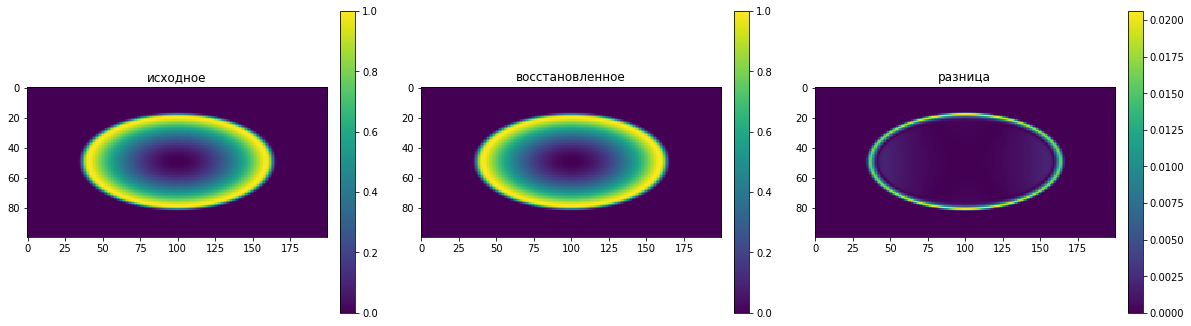

In [55]:
def _f1(g1, h1):
    """
    F1 составлющая матрицы F
    :param g1: 2d array. Градиент по x
    :param h1: шаг сетки по x
    :return: 2d array
    """
    dim = g1.shape
    tmp = np.dot(matrixes.create_g1(dim[0], h1), g1)
    return np.dot(matrixes.create_b(dim[0], h1), tmp)


def _f2(g2, h2):
    """
    F2 составляющая матрицы F
    :param g2: 2d array. Градиент по y
    :param h2: шаг сетки по y
    :return: 2d array
    """
    dim = g2.shape
    tmp = np.dot(matrixes.create_b(dim[0], h2), g2)
    return np.dot(tmp, matrixes.create_g2(dim[1], h2))


def _get_f_matrix(g1, g2, h1, h2):
    """
    Матрица F. Правая часть в разностной схеме метода.
    :param g1: 2d array. Градиент по x
    :param g2: 2d array. Градиент по y
    :param h1: Шаг сетки по x
    :param h2: Шаг сетки по y
    :return: 2d array
    """
    return _f1(g1, h1) + _f2(g2, h2)


def method(g1, g2, h1, h2, alpha, gamma):
    """
    Метод. Принимает градиенты по x, y. Параметры регуляризации alga, gamma.
    Возвращает восстановленный волновой фронт.
    :param g1: 2d array. Градиент по x
    :param g2: 2d array. Градиент по y
    :param h1: Шаг сетки по x
    :param h2: Шаг сетки по y
    :param alpha: параметр регуляризации
    :param gamma: параметр регуляризации
    :return:
    """
    f = np.fft.fft2(_get_f_matrix(g1, g2, h1, h2))

    lambda1 = eigenvalues.get_lambda(f.shape[0], h1)
    lambda2 = eigenvalues.get_lambda(f.shape[1], h2)

    mu1 = eigenvalues.get_mu(f.shape[0], h1)
    mu2 = eigenvalues.get_mu(f.shape[1], h2)

    res = np.zeros(f.shape, dtype=complex)
    for k in range(res.shape[0]):
        for l in range(res.shape[1]):
            res[k][l] = (lambda1[k] * mu2[l] + mu1[k] * lambda2[l] +
                         alpha * mu1[k] * mu2[l] + gamma * lambda1[k] * lambda2[l])
    res = np.fft.ifft2(f / res)
    return np.real(res)
restored_front = method(g1, g2, h1, h2, 0.001, 0.001)
report(restored_front)

# 8. $F = B_1 (g_1 G_1)+ B_2 (g_2 G_2) $

# 9. $F = (G_1 g_1) B_1 + B_2 G_2 g_2 $

# 9. $F = B_2 G_1 g_1 + B_1 G_2 g_2 $

# Итоги:
1. Есть нестрогое обоснование
2. В реализации найдены ошибки, нужно h2, h1 было чередовать. Необходимо исправить.

# Теоритическое обоснование


$(g^1, \phi_x) = \sum \limits_{n = 0}^{N_1 - 1} \sum \limits_{m = 0}^{N_2 - 1} \int \limits_0^{2\pi}\int \limits_0^{2\pi} g^1_{nm}\phi_n(x)\phi_m(y) \phi'_k(x) \phi_l(y) dx dy = 
\sum \limits_{n = 0}^{N_1 - 1} \sum \limits_{m = 0}^{N_2 - 1} g^1_{nm} \int \limits_0^{2\pi} \phi_n(x) \phi'_k(x) dx \int \limits_0^{2\pi} \phi_m(y) \phi_l(y) dy$

$\int \limits_0^{2\pi} \phi_n(x) \phi'_k(x) dx  = G_{kn} =
\begin{cases} 
    0, \, k = n \\ 
    -1, \, k - n = -1 \\
    1, \, n - k = 1 \\
    0, else
\end{cases}$

$\int \limits_0^{2\pi} \phi_m(y) \phi_l(y) dy = B_{ml} =
\begin{cases}
    \frac{2}{3}, \, m = l \\
    \frac{1}{6}, \mid m-l \mid = 1\\
    0, else
\end{cases}$

$(g^1, \phi_x) = \sum \limits_{n = 0}^{N_1 - 1} \sum \limits_{m = 0}^{N_2 - 1} g^1_{nm} G_{kn} B_{ml} = 
\sum \limits_{n = 0}^{N_1 - 1} \big(\sum \limits_{m = 0}^{N_2 - 1} G_{kn} g^1_{nm} \big) B_{ml} = G_1 g^1 B_2
$